In [105]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import QUANTAXIS as QA
import pandas as pd
import numpy as np
import pyecharts
import talib

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

import matplotlib.pyplot as plt

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [106]:
stock_code='601398'
benchmark_code='399300'
start_time='2005-01-01'
end_time='2018-12-31'

data_raw=QA.QA_fetch_stock_day_adv(stock_code, start_time, end_time).to_qfq().data.reset_index().set_index('date')
data_raw.head(1)

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922


In [3]:
data=data_raw.drop(columns=['code','amount','preclose','adj'])
data.head(1)

,open,high,low,close,volume
date,,,,,
2006-10-27,1.992133,2.01557,1.910104,1.921823,4.407654e+07


## 对数据进行包装

### 增加特性数据

In [4]:
def augFeatures(train):
    df=train.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["date"] = df.index.day
    df["day"] = df.index.dayofweek
    return df

### 正则化

In [5]:
def normalize(train):
    return train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

### 其他方法

In [81]:
def buildData(df,pastDays=30,futureDays=5):
    """取 `pastDays` 的数据作为计算数据，取 `futureDays` 的 `close` %save据作为测算数据。
    返回的X集合中包含类型为 `DataFrame` ，Y集合中包含为 `Series`。"""
    X,Y=[],[]
    for i in range(df.shape[0]-pastDays-futureDays):
        X.append(df.iloc[i:i+pastDays])
        Y.append(df.iloc[i+pastDays:i+pastDays+futureDays]['close'])
    return X,Y

# def splitBuildData(X,Y,test_size=0.2,random_state=10,shuffle=True):
#     """调用 `sklearn.model_selection.train_test_split` callable分训练集和测试集。
#     Args:
#         shuffle: 是否打乱数据。默认为 `True`。
        
#     Returns:
#         返回内容为：X_train, X_test, y_train, y_test。
#         其中 X_train和y_train配对，X_test和y_test配对。"""
#     return train_test_split(X,Y,test_size=test_size,random_state=random_state,shuffle=shuffle)

def toNpArray(d):
    return np.array([np.array(x.values) for x in d])

## 数据演示

In [77]:
data = data_raw.drop(columns=['code','amount','preclose','adj'])
# 包装数据
data_Aug = augFeatures(data)
# 归一化数据
data_norm = normalize(data_Aug)
# 构建结果集
X,Y=buildData(data_norm)
# 按顺序拆分数据和结果
X_train, X_test, y_train, y_test = splitBuildData(X, Y,shuffle=False)

In [79]:
#X_train集合中每一个元素（30天的数据）与X集合中每一个元素的对应关系（因为是按照顺序拆分的）
X_train[0]
np.array([np.array(x.values) for x in X])[0]

,open,high,low,close,volume,year,month,date,day
date,,,,,,,,,
2006-10-27,-0.290901,-0.286750,-0.305056,-0.297344,0.947017,-0.535039,0.303473,0.362010,0.497366
2006-10-30,-0.305110,-0.299520,-0.306172,-0.296279,0.080294,-0.535039,0.303473,0.462010,-0.502634
2006-10-31,-0.304017,-0.298456,-0.302826,-0.295213,0.032970,-0.535039,0.303473,0.495343,-0.252634
2006-11-01,-0.301831,-0.300584,-0.302826,-0.295213,-0.004811,-0.535039,0.394382,-0.504657,-0.002634
2006-11-02,-0.301831,-0.301648,-0.306172,-0.297344,0.011611,-0.535039,0.394382,-0.471323,0.247366
2006-11-03,-0.305110,-0.294199,-0.303941,-0.288819,0.098982,-0.535039,0.394382,-0.437990,0.497366
2006-11-06,-0.298552,-0.293135,-0.298366,-0.286688,0.025147,-0.535039,0.394382,-0.337990,-0.502634
2006-11-07,-0.293087,-0.287814,-0.292790,-0.284557,0.058874,-0.535039,0.394382,-0.304657,-0.252634
2006-11-08,-0.290901,-0.291007,-0.295020,-0.288819,0.002545,-0.535039,0.394382,-0.271323,-0.002634


array([[-0.290901  , -0.28674996, -0.30505644, -0.2973442 ,  0.94701728,
        -0.53503852,  0.30347321,  0.36200997,  0.49736574],
       [-0.30510993, -0.29952003, -0.30617156, -0.29627859,  0.08029418,
        -0.53503852,  0.30347321,  0.46200997, -0.50263426],
       [-0.30401693, -0.29845586, -0.30282621, -0.29521298,  0.03296992,
        -0.53503852,  0.30347321,  0.4953433 , -0.25263426],
       [-0.30183094, -0.3005842 , -0.30282621, -0.29521298, -0.00481098,
        -0.53503852,  0.3943823 , -0.5046567 , -0.00263426],
       [-0.30183094, -0.30164837, -0.30617156, -0.2973442 ,  0.01161062,
        -0.53503852,  0.3943823 , -0.47132336,  0.24736574],
       [-0.30510993, -0.29419917, -0.30394132, -0.28881931,  0.09898188,
        -0.53503852,  0.3943823 , -0.43799003,  0.49736574],
       [-0.29855196, -0.293135  , -0.29836574, -0.28668809,  0.02514733,
        -0.53503852,  0.3943823 , -0.33799003, -0.50263426],
       [-0.29308699, -0.28781414, -0.29279015, -0.28455687,  0

In [82]:
#将原本的集合中包含DataFrame的X，或者集合中包含Series的Y，转换成np.array类型
X_train=toNpArray(X_train)
X_test=toNpArray(X_test)
y_train=toNpArray(y_train)
y_test=toNpArray(y_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2325, 30, 9), (582, 30, 9), (2325, 5), (582, 5))

https://keras.io/zh/layers/recurrent/#lstm
    
[Sequential 顺序模型指引](https://keras.io/zh/getting-started/sequential-model-guide/)

In [95]:
def buildManyToManyModel(shape):
    model = Sequential()
    #input_dim: 输入的维度（整数）。 将此层用作模型中的第一层时，此参数（或者，关键字参数 input_shape）是必需的。
    #input_length: 输入序列的长度，在恒定时指定。 
    #如果你要在上游连接 Flatten 和 Dense 层， 则需要此参数（如果没有它，无法计算全连接输出的尺寸）。 
    #请注意，如果循环神经网络层不是模型中的第一层， 则需要在第一层的层级指定输入长度（例如，通过 input_shape 参数）。
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # 
    model.add(Dense(5))
    # 模型编译
    # 在训练模型之前，您需要配置学习过程，这是通过 compile 方法完成的。它接收三个参数：

    # 优化器 optimizer。它可以是现有优化器的字符串标识符，如 rmsprop 或 adagrad，也可以是 Optimizer 类的实例。
    # 详见：optimizers。
    # 损失函数 loss，模型试图最小化的目标函数。它可以是现有损失函数的字符串标识符，
    # 如 categorical_crossentropy 或 mse，也可以是一个目标函数。详见：losses。
    # 评估标准 metrics。对于任何分类问题，你都希望将其设置为 metrics = ['accuracy']。
    # 评估标准可以是现有的标准的字符串标识符，也可以是自定义的评估标准函数。
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [101]:
data = data_raw.drop(columns=['code','amount','preclose','adj'])
data_Aug = augFeatures(data)
data_norm = normalize(data_Aug)
X,Y=buildData(data_norm)
# X_train, X_test, y_train, y_test = splitBuildData(X, Y)

# X_train=toNpArray(X_train)
# X_test=toNpArray(X_test)
# y_train=toNpArray(y_train)
# y_test=toNpArray(y_test)

X_np=toNpArray(X)
Y_np=toNpArray(Y)

model = buildManyToManyModel(X_train.shape)
cb_loss = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
cb_acc = EarlyStopping(monitor="acc", patience=10, verbose=1, mode="auto")
# epochs: 整数。训练模型迭代轮次。一个轮次是在整个 x 或 y 上的一轮迭代。
#     请注意，与 initial_epoch 一起，epochs 被理解为 「最终轮次」。
#     模型并不是训练了 epochs 轮，而是到第 epochs 轮停止训练。
# batch_size: 整数或 None。每次提度更新的样本数。如果未指定，默认为 32.
# validation_split: 在 0 和 1 之间浮动。用作验证集的训练数据的比例。
#     模型将分出一部分不会被训练的验证数据，并将在每一轮结束时评估这些验证数据的误差和任何其他模型指标。
#     验证数据是混洗之前 x 和y 数据的最后一部分样本中。
# shuffle: 布尔值（是否在每轮迭代之前混洗数据）或者 字符串 (batch)。
#     batch 是处理 HDF5 数据限制的特殊选项，它对一个 batch 内部的数据进行混洗。
#     当 steps_per_epoch 非 None 时，这个参数无效。
# validation_data: 元组 (x_val，y_val) 或元组 (x_val，y_val，val_sample_weights)，用来评估损失，
#     以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
#     这个参数会覆盖 validation_split。
history=model.fit(X_np, Y_np, epochs=1000, batch_size=128, validation_split=0.15, callbacks=[cb_loss,cb_acc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10)                800       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 55        
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________
Train on 2470 samples, validate on 437 samples
Epoch 1/1000
2470/2470 [==============================] - 2s 885us/step - loss: 0.0275 - val_loss: 0.2189
Epoch 2/1000
2470/2470 [==============================] - 1s 277us/step - loss: 0.0137 - val_loss: 0.1485
Epoch 3/1000
2470/2470 [==============================] - 1s 304us/step - loss: 0.0073 - val_loss: 0.0872
Epoch 4/1000
2470/2470 [==============================] - 1s 322us/step - loss: 0.0036 - val_loss: 0.0512
Epoch 5/1000
2470/2470 [==============================] - 1s 306us/st

2470/2470 [==============================] - 1s 318us/step - loss: 4.7021e-04 - val_loss: 0.0185
Epoch 70/1000
2470/2470 [==============================] - 1s 325us/step - loss: 4.7033e-04 - val_loss: 0.0185
Epoch 71/1000
2470/2470 [==============================] - 1s 313us/step - loss: 4.6730e-04 - val_loss: 0.0188
Epoch 72/1000
2470/2470 [==============================] - 1s 302us/step - loss: 4.6589e-04 - val_loss: 0.0184
Epoch 73/1000
2470/2470 [==============================] - 1s 321us/step - loss: 4.6424e-04 - val_loss: 0.0181
Epoch 74/1000
2470/2470 [==============================] - 1s 332us/step - loss: 4.7179e-04 - val_loss: 0.0182
Epoch 75/1000
2470/2470 [==============================] - 1s 328us/step - loss: 4.6474e-04 - val_loss: 0.0180
Epoch 76/1000
2470/2470 [==============================] - 1s 269us/step - loss: 4.6197e-04 - val_loss: 0.0176
Epoch 77/1000
2470/2470 [==============================] - 1s 294us/step - loss: 4.5910e-04 - val_loss: 0.0175
Epoch 78/1000
2

2470/2470 [==============================] - 1s 306us/step - loss: 4.0390e-04 - val_loss: 0.0101
Epoch 143/1000
2470/2470 [==============================] - 1s 315us/step - loss: 4.0148e-04 - val_loss: 0.0101
Epoch 144/1000
2470/2470 [==============================] - 1s 303us/step - loss: 4.0096e-04 - val_loss: 0.0102
Epoch 145/1000
2470/2470 [==============================] - 1s 306us/step - loss: 4.0120e-04 - val_loss: 0.0100
Epoch 146/1000
2470/2470 [==============================] - 1s 312us/step - loss: 4.0338e-04 - val_loss: 0.0106
Epoch 147/1000
2470/2470 [==============================] - 1s 308us/step - loss: 3.9946e-04 - val_loss: 0.0099
Epoch 148/1000
2470/2470 [==============================] - 1s 318us/step - loss: 3.9896e-04 - val_loss: 0.0099
Epoch 149/1000
2470/2470 [==============================] - 1s 316us/step - loss: 3.9854e-04 - val_loss: 0.0100
Epoch 150/1000
2470/2470 [==============================] - 1s 271us/step - loss: 3.9831e-04 - val_loss: 0.0095
Epoch 1

2470/2470 [==============================] - 1s 312us/step - loss: 3.6923e-04 - val_loss: 0.0071
Epoch 216/1000
2470/2470 [==============================] - 1s 320us/step - loss: 3.6639e-04 - val_loss: 0.0070
Epoch 217/1000
2470/2470 [==============================] - 1s 314us/step - loss: 3.6758e-04 - val_loss: 0.0071
Epoch 218/1000
2470/2470 [==============================] - 1s 295us/step - loss: 3.6615e-04 - val_loss: 0.0072
Epoch 219/1000
2470/2470 [==============================] - 1s 331us/step - loss: 3.6605e-04 - val_loss: 0.0069
Epoch 220/1000
2470/2470 [==============================] - 1s 307us/step - loss: 3.7404e-04 - val_loss: 0.0078
Epoch 221/1000
2470/2470 [==============================] - 1s 269us/step - loss: 3.6759e-04 - val_loss: 0.0066
Epoch 222/1000
2470/2470 [==============================] - 1s 320us/step - loss: 3.6520e-04 - val_loss: 0.0073
Epoch 223/1000
2470/2470 [==============================] - 1s 332us/step - loss: 3.6628e-04 - val_loss: 0.0071
Epoch 2

2470/2470 [==============================] - 1s 297us/step - loss: 3.4334e-04 - val_loss: 0.0057
Epoch 289/1000
2470/2470 [==============================] - 1s 318us/step - loss: 3.4627e-04 - val_loss: 0.0058
Epoch 290/1000
2470/2470 [==============================] - 1s 319us/step - loss: 3.4389e-04 - val_loss: 0.0056
Epoch 291/1000
2470/2470 [==============================] - 1s 294us/step - loss: 3.4974e-04 - val_loss: 0.0064
Epoch 292/1000
2470/2470 [==============================] - 1s 325us/step - loss: 3.4665e-04 - val_loss: 0.0058
Epoch 293/1000
2470/2470 [==============================] - 1s 328us/step - loss: 3.4294e-04 - val_loss: 0.0056
Epoch 294/1000
2470/2470 [==============================] - 1s 328us/step - loss: 3.4510e-04 - val_loss: 0.0057
Epoch 295/1000
2470/2470 [==============================] - 1s 265us/step - loss: 3.4571e-04 - val_loss: 0.0060
Epoch 296/1000
2470/2470 [==============================] - 1s 318us/step - loss: 3.4282e-04 - val_loss: 0.0058
Epoch 2

2470/2470 [==============================] - 1s 279us/step - loss: 3.3015e-04 - val_loss: 0.0050
Epoch 362/1000
2470/2470 [==============================] - 1s 315us/step - loss: 3.2671e-04 - val_loss: 0.0051
Epoch 363/1000
2470/2470 [==============================] - 1s 326us/step - loss: 3.2469e-04 - val_loss: 0.0052
Epoch 364/1000
2470/2470 [==============================] - 1s 308us/step - loss: 3.2318e-04 - val_loss: 0.0049
Epoch 365/1000
2470/2470 [==============================] - 1s 290us/step - loss: 3.2366e-04 - val_loss: 0.0052
Epoch 366/1000
2470/2470 [==============================] - 1s 293us/step - loss: 3.2489e-04 - val_loss: 0.0047
Epoch 367/1000
2470/2470 [==============================] - 1s 283us/step - loss: 3.2321e-04 - val_loss: 0.0048
Epoch 368/1000
2470/2470 [==============================] - 1s 313us/step - loss: 3.2163e-04 - val_loss: 0.0049
Epoch 369/1000
2470/2470 [==============================] - 1s 318us/step - loss: 3.2110e-04 - val_loss: 0.0049
Epoch 3

2470/2470 [==============================] - 1s 326us/step - loss: 3.0440e-04 - val_loss: 0.0046
Epoch 435/1000
2470/2470 [==============================] - 1s 293us/step - loss: 3.0392e-04 - val_loss: 0.0044
Epoch 436/1000
2470/2470 [==============================] - 1s 309us/step - loss: 3.0471e-04 - val_loss: 0.0046
Epoch 437/1000
2470/2470 [==============================] - 1s 327us/step - loss: 3.0285e-04 - val_loss: 0.0046
Epoch 438/1000
2470/2470 [==============================] - 1s 322us/step - loss: 3.0195e-04 - val_loss: 0.0046
Epoch 439/1000
2470/2470 [==============================] - 1s 317us/step - loss: 3.0361e-04 - val_loss: 0.0047
Epoch 440/1000
2470/2470 [==============================] - 1s 324us/step - loss: 3.0297e-04 - val_loss: 0.0044
Epoch 441/1000
2470/2470 [==============================] - 1s 311us/step - loss: 3.0255e-04 - val_loss: 0.0049
Epoch 442/1000
2470/2470 [==============================] - 1s 318us/step - loss: 3.0293e-04 - val_loss: 0.0050
Epoch 4

In [108]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

KeyError: 'acc'

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

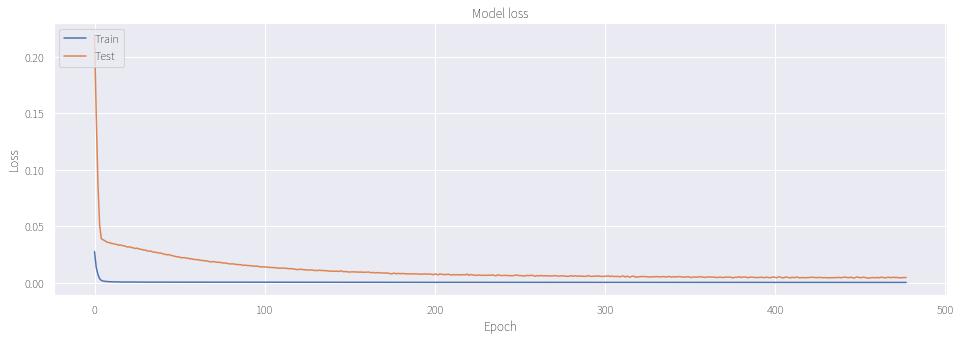

In [107]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 10 arrays: [array([[ 0.39517846,  0.38969461,  0.38387677,  0.36796524, -0.01403759,
         0.46496148,  0.30347321,  0.42867664, -0.50263426],
       [ 0.38398589,  0.37879719,  0.38958632,  0.37705869, -0.02...